In [7]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

### Definition of basic functions

In [8]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Saves GIF file from image files"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

def exact_solution(d, w0, x):
    """
    Analytical solution to the 1D underdamped harmonic oscillator problem.
    """
    assert d < w0
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi + w*x)
    sin = torch.sin(phi + w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

class DNN(nn.Module):
    """
    Defines a connected network
    ============================================================================
    N_INPUT: number of input variables
    N_OUTPUT: number of output variables
    N_HIDDEN: number of units per hidden layer
    N_LAYERS: number of hidden layers
    ============================================================================
    """
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh  # The tanh activation restricts output to [-1, 1] 
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

### Training the Deep Neural Network using only data from the known solution.

Analytical solution size:  torch.Size([500, 1]) torch.Size([500, 1])
Training points:  torch.Size([10, 1]) torch.Size([10, 1])


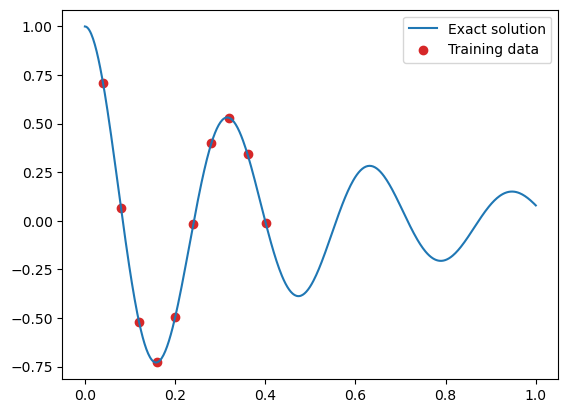

In [9]:
# Parameters of the differential equation
d, w0 = 2, 20

# Initial condition
x0 = 0.
y0 = 1.


# Domain of integration
x = torch.linspace(x0,1,500).view(-1,1)

# Analytical solution over the full domain
y = exact_solution(d, w0, x).view(-1,1)
print('Analytical solution size: ',x.shape, y.shape)

# Initial condition in tensor form
x0 = torch.tensor(x0).view(-1,1)
y0 = torch.tensor(y0).view(-1,1)

# slice out a small number of points (10) from the domain
x_data = x[20:220:20]
y_data = y[20:220:20]
print('Training points: ',x_data.shape, y_data.shape)

# Plot of the exact solution
plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:red", label="Training data")
plt.legend()
plt.show()

Epoch:  100  Loss:  0.20320717990398407
Epoch:  200  Loss:  0.18550223112106323
Epoch:  300  Loss:  0.0017549643525853753
Epoch:  400  Loss:  0.0003684458788484335
Epoch:  500  Loss:  0.000172135274624452
Epoch:  600  Loss:  0.00010237369133392349
Epoch:  700  Loss:  6.889742508064955e-05
Epoch:  800  Loss:  5.3565181588055566e-05
Epoch:  900  Loss:  4.007639654446393e-05
Epoch:  1000  Loss:  3.3590324164833874e-05


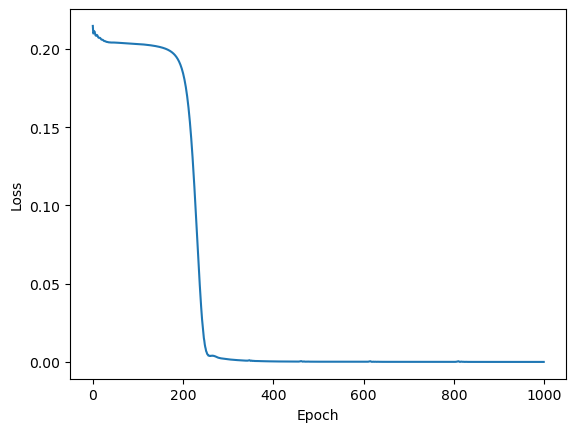

In [11]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    plt.scatter(x0, y0, s=60, color="tab:red", alpha=0.4, label='Initial Condition')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4,
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1, 1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")


# Train the standard neural network to fit the training data

epochs = 1000

torch.manual_seed(413)
model = DNN(1,1,32,3) # 1 input, 1 output, 32 neurons in 3 hidden layers
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
loss_history = []

for i in range(1000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2) # mean squared error
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())


    # Save plots of the training
    if (i+1) % 10 == 0:
        yh = model(x).detach()
        plot_result(x,y,x_data,y_data,yh)
        file = "plots/nn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        plt.close()

        #if (i+1) % 500 == 0: plt.show()
        #else: plt.close("all")

    if (i+1) %100 ==0: print('Epoch: ', i+1, ' Loss: ', loss.item())

save_gif_PIL("nn.gif", files, fps=20, loop=0)

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Definition of the PINN and training using data from the differential equation, the initial condition and some known data from the exact solution.

Epoch:  500  Loss:  0.9851399660110474
Epoch:  1000  Loss:  0.8561578392982483
Epoch:  1500  Loss:  0.756472110748291
Epoch:  2000  Loss:  0.4321592152118683
Epoch:  2500  Loss:  0.24682769179344177
Epoch:  3000  Loss:  0.12743718922138214
Epoch:  3500  Loss:  0.0912424847483635
Epoch:  4000  Loss:  0.058381058275699615
Epoch:  4500  Loss:  0.03589216247200966
Epoch:  5000  Loss:  0.028758781030774117
Epoch:  5500  Loss:  0.02076176181435585
Epoch:  6000  Loss:  0.01500551588833332
Epoch:  6500  Loss:  0.013156351633369923
Epoch:  7000  Loss:  0.012114744633436203
Epoch:  7500  Loss:  0.011165281757712364
Epoch:  8000  Loss:  0.010167212225496769
Epoch:  8500  Loss:  0.009150889702141285
Epoch:  9000  Loss:  0.008191488683223724
Epoch:  9500  Loss:  0.007107618264853954
Epoch:  10000  Loss:  0.005007290747016668
Epoch:  10500  Loss:  0.002651752205565572
Epoch:  11000  Loss:  0.0010423980420455337
Epoch:  11500  Loss:  0.00041320855962112546
Epoch:  12000  Loss:  0.00024363808915950358

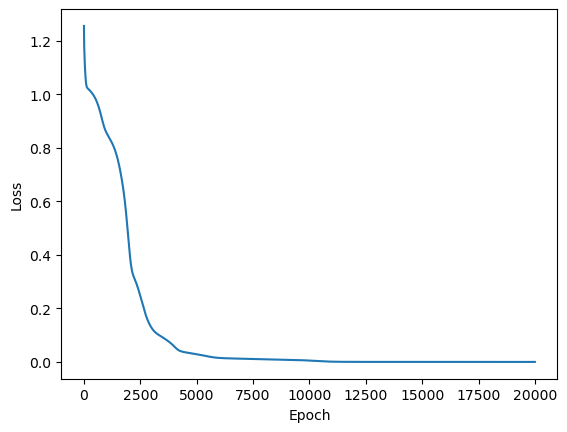

In [12]:
# Sample locations over the problem domain
x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# Parameters in the differential equation
mu, k = 2*d, w0**2

epochs = 20000
torch.manual_seed(413)
model = DNN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []
loss_history = []

for i in range(epochs):
    optimizer.zero_grad()

    # compute the "initial condition loss"
    y0h = model(x0)
    loss1 = torch.mean((y0h-y0)**2)# use mean squared error

    # compute the "data loss"
    yh = model(x_data)
    loss2 = torch.mean((yh-y_data)**2)# use mean squared error

    # compute the "physics loss"
    yhp = model(x_physics)
    dydx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dydx2 = torch.autograd.grad(dydx,  x_physics, torch.ones_like(dydx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dydx2 + mu*dydx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
    loss3 = (1e-4)*torch.mean(physics**2)

    # backpropagate joint loss
    loss = loss1 + loss2 + loss3 # add two loss terms together
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    # plot the result as training progresses
    if (i+1) % 150 == 0:

        yh = model(x).detach()
        xp = x_physics.detach()

        plot_result(x,y,x_data,y_data,yh,xp)

        file = "plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        #if (i+1) % 6000 == 0: plt.show()
        #else: plt.close("all")
        plt.close()

    if (i+1) %500 ==0: print('Epoch: ', i+1, ' Loss: ', loss.item())

save_gif_PIL("pinn1.gif", files, fps=20, loop=0)

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Definition of the PINN and training using data from the differential equation and the initial condition.

Epoch:  500  Loss:  0.27004513144493103
Epoch:  1000  Loss:  0.22127413749694824
Epoch:  1500  Loss:  0.14850905537605286
Epoch:  2000  Loss:  0.09892698377370834
Epoch:  2500  Loss:  0.0740690752863884
Epoch:  3000  Loss:  0.04363750293850899
Epoch:  3500  Loss:  0.028666971251368523
Epoch:  4000  Loss:  0.020007401704788208
Epoch:  4500  Loss:  0.015713153406977654
Epoch:  5000  Loss:  0.01197653915733099
Epoch:  5500  Loss:  0.008564822375774384
Epoch:  6000  Loss:  0.007146206218749285
Epoch:  6500  Loss:  0.006127440836280584
Epoch:  7000  Loss:  0.004766867496073246
Epoch:  7500  Loss:  0.002777672838419676
Epoch:  8000  Loss:  0.0011801975779235363
Epoch:  8500  Loss:  0.00035027123522013426
Epoch:  9000  Loss:  6.970948015805334e-05
Epoch:  9500  Loss:  1.528671054984443e-05
Epoch:  10000  Loss:  6.260258942347718e-06
Epoch:  10500  Loss:  3.7100321605976205e-06
Epoch:  11000  Loss:  2.041861307588988e-06
Epoch:  11500  Loss:  1.2545988283818588e-06
Epoch:  12000  Loss:  7.1151

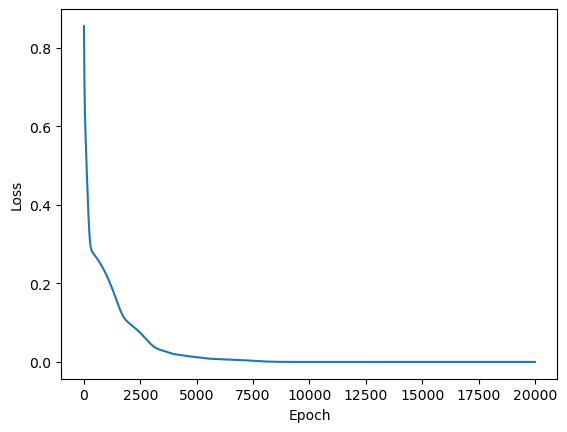

In [9]:
# Sample locations over the problem domain
x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# Parameters in the differential equation
mu, k = 2*d, w0**2

epochs = 20000
torch.manual_seed(413)
model = DNN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []
loss_history = []

for i in range(epochs):
    optimizer.zero_grad()

    # compute the "initial condition loss"
    y0h = model(x0)
    loss1 = torch.mean((y0h-y0)**2)# use mean squared error

    # compute the "data loss"
    #yh = model(x_data)
    #loss2 = torch.mean((yh-y_data)**2)# use mean squared error
    loss2 = 0

    # compute the "physics loss"
    yhp = model(x_physics)
    dydx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dydx2 = torch.autograd.grad(dydx,  x_physics, torch.ones_like(dydx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dydx2 + mu*dydx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
    loss3 = (1e-5)*torch.mean(physics**2)

    # backpropagate joint loss
    loss = loss1 + loss2 + loss3 # add two loss terms together
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    # plot the result as training progresses
    if (i+1) % 150 == 0:

        yh = model(x).detach()
        xp = x_physics.detach()

        plot_result(x,y,x_data,y_data,yh,xp)

        file = "plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        #if (i+1) % 6000 == 0: plt.show()
        #else: plt.close("all")
        plt.close()

    if (i+1) %500 ==0: print('Epoch: ', i+1, ' Loss: ', loss.item())

save_gif_PIL("pinn2.gif", files, fps=20, loop=0)

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()